# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:1000]
    y_subset = y_train[:1000]
    
    # Create KNN graph
    k = 1  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")
    
    return data



data = main()
generate_train_test(data)

# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



# Autoencoder Settings
input_dim = data.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, data.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.17230021953582764
Epoch 10, Loss: 0.059980347752571106
Epoch 20, Loss: 0.045454829931259155
Epoch 30, Loss: 0.036995839327573776
Epoch 40, Loss: 0.03039451688528061
Epoch 50, Loss: 0.027430888265371323
Epoch 60, Loss: 0.02535887621343136
Epoch 70, Loss: 0.023647373542189598
Epoch 80, Loss: 0.022371800616383553
Epoch 90, Loss: 0.021534176543354988
Epoch 100, Loss: 0.021345190703868866
Epoch 110, Loss: 0.021002205088734627
Epoch 120, Loss: 0.019756974652409554
Epoch 130, Loss: 0.019191250205039978
Epoch 140, Loss: 0.018580911681056023
Epoch 150, Loss: 0.018784604966640472
Epoch 160, Loss: 0.01786087267100811
Epoch 170, Loss: 0.017578190192580223
Epoch 180, Loss: 0.017272749915719032
Epoch 190, Loss: 0.01840830221772194
Epoch 0, Loss: 4.967663288116455
Epoch 10, Loss: 1.0599747896194458
Epoch 20, Loss: 0.8018714785575867
Epoch 30, Loss: 0.726366400718689
Epoch 40, Loss: 0.717867374420166
Epoch 50, Loss: 0.6644938588142395
Epoch 60, Loss: 0.619185209274292
Epoch 70, Loss: 

In [3]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [4]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862961530685425
Epoch: 20, Loss: 1.386301040649414
Epoch: 30, Loss: 1.3863043785095215
Epoch: 40, Loss: 1.3863060474395752
Epoch: 50, Loss: 1.3863065242767334
Epoch: 60, Loss: 1.3863067626953125
Epoch: 70, Loss: 1.3863067626953125
Epoch: 80, Loss: 1.3863067626953125
Epoch: 90, Loss: 1.386306643486023
Epoch: 100, Loss: 1.3863065242767334
Epoch 0, Loss: 2.3038482666015625
Epoch 10, Loss: 2.300630807876587
Epoch 20, Loss: 2.2979326248168945
Epoch 30, Loss: 2.3012208938598633
Epoch 40, Loss: 2.2996580600738525
Epoch 50, Loss: 2.3000519275665283
Epoch 60, Loss: 2.2991204261779785
Epoch 70, Loss: 2.2994699478149414
Epoch 80, Loss: 2.298426866531372
Epoch 90, Loss: 2.2975478172302246


## 

In [6]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.0950


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [7]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3855873346328735
Epoch: 20, Loss: 1.386594533920288
Epoch: 30, Loss: 1.3867874145507812
Epoch: 40, Loss: 1.3868303298950195
Epoch: 50, Loss: 1.3867905139923096
Epoch: 60, Loss: 1.3867255449295044
Epoch: 70, Loss: 1.3866620063781738
Epoch: 80, Loss: 1.3866081237792969
Epoch: 90, Loss: 1.3865642547607422
Epoch: 100, Loss: 1.3865288496017456
Epoch 0, Loss: 2.3019862174987793
Epoch 10, Loss: 2.297781467437744
Epoch 20, Loss: 2.297372817993164
Epoch 30, Loss: 2.297534227371216
Epoch 40, Loss: 2.299351453781128
Epoch 50, Loss: 2.2973828315734863
Epoch 60, Loss: 2.2975411415100098
Epoch 70, Loss: 2.2975499629974365
Epoch 80, Loss: 2.2961416244506836
Epoch 90, Loss: 2.2947683334350586


## 

In [9]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1050


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [10]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3862977027893066
Epoch: 20, Loss: 1.3863062858581543
Epoch: 30, Loss: 1.386312484741211
Epoch: 40, Loss: 1.3863153457641602
Epoch: 50, Loss: 1.386316180229187
Epoch: 60, Loss: 1.3863165378570557
Epoch: 70, Loss: 1.3863165378570557
Epoch: 80, Loss: 1.386316180229187
Epoch: 90, Loss: 1.3863160610198975
Epoch: 100, Loss: 1.3863158226013184


## 

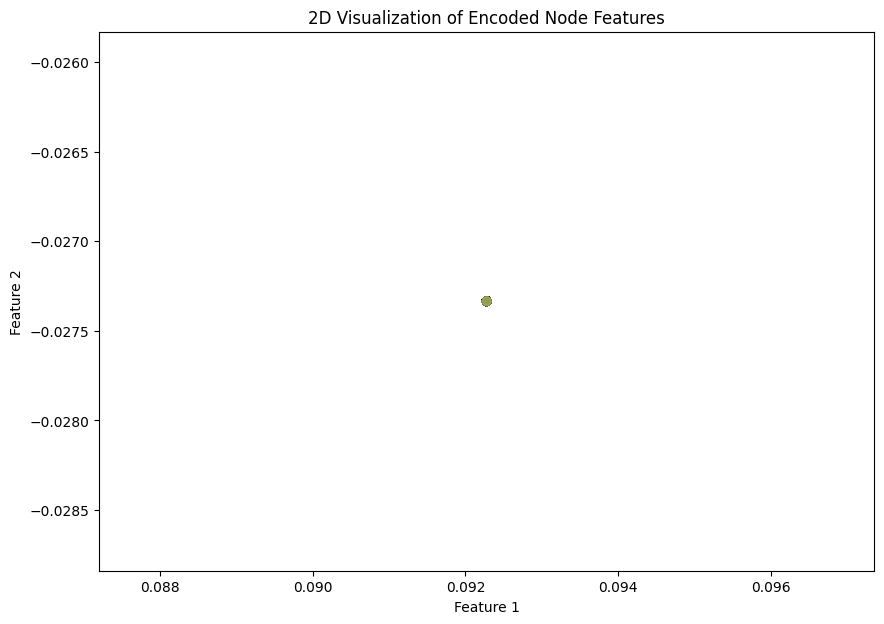

In [12]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [13]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 34.53877639770508
Epoch: 20, Loss: 34.50985336303711
Epoch: 30, Loss: 19.76263999938965
Epoch: 40, Loss: 9.876082420349121
Epoch: 50, Loss: 4.142862319946289
Epoch: 60, Loss: 1.2148298025131226
Epoch: 70, Loss: 1.031812310218811
Epoch: 80, Loss: 0.9421334266662598
Epoch: 90, Loss: 0.9210939407348633
Epoch: 100, Loss: 0.929999828338623
Epoch: 110, Loss: 0.8959044218063354
Epoch: 120, Loss: 0.8885023593902588
Epoch: 130, Loss: 0.9169945120811462
Epoch: 140, Loss: 0.9054049849510193
Epoch: 150, Loss: 0.9168169498443604
Epoch: 160, Loss: 0.9854646921157837
Epoch: 170, Loss: 0.9277403950691223
Epoch: 180, Loss: 0.8896690011024475
Epoch: 190, Loss: 0.8821163177490234
Epoch: 200, Loss: 0.9215232729911804


## 

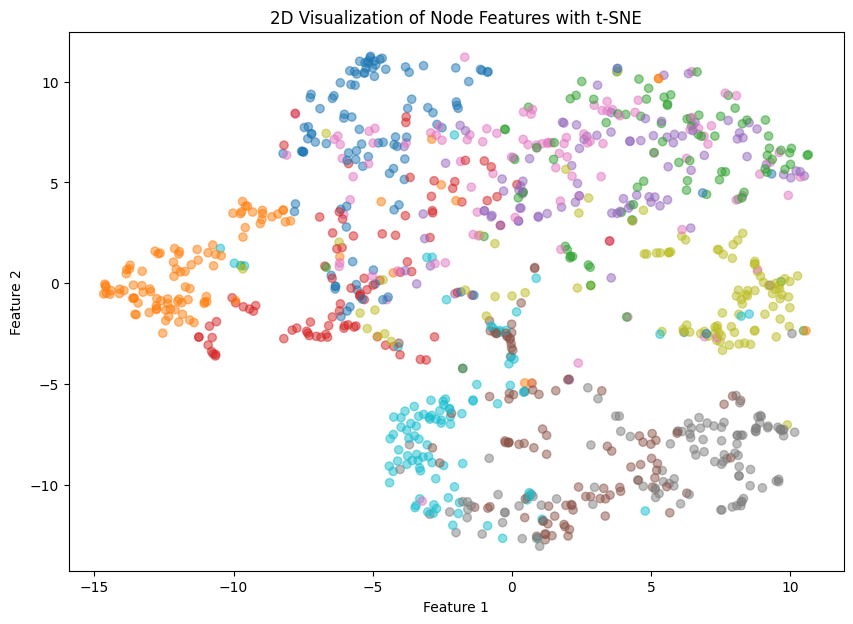

In [15]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [16]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [17]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.3361947536468506
Epoch: 20, Loss: 1.3589248657226562
Epoch: 30, Loss: 1.252636194229126
Epoch: 40, Loss: 1.068451166152954
Epoch: 50, Loss: 1.0677201747894287
Epoch: 60, Loss: 1.0705201625823975
Epoch: 70, Loss: 1.001428246498108
Epoch: 80, Loss: 1.0344141721725464
Epoch: 90, Loss: 0.9868261814117432
Epoch: 100, Loss: 1.022539734840393
Epoch: 110, Loss: 1.0250340700149536
Epoch: 120, Loss: 0.9638811945915222
Epoch: 130, Loss: 0.9936129450798035
Epoch: 140, Loss: 0.994282603263855
Epoch: 150, Loss: 1.0070958137512207
Epoch: 160, Loss: 0.993179976940155
Epoch: 170, Loss: 1.0121992826461792
Epoch: 180, Loss: 0.9937971830368042
Epoch: 190, Loss: 1.0400465726852417
Epoch: 200, Loss: 0.9800152778625488


## 

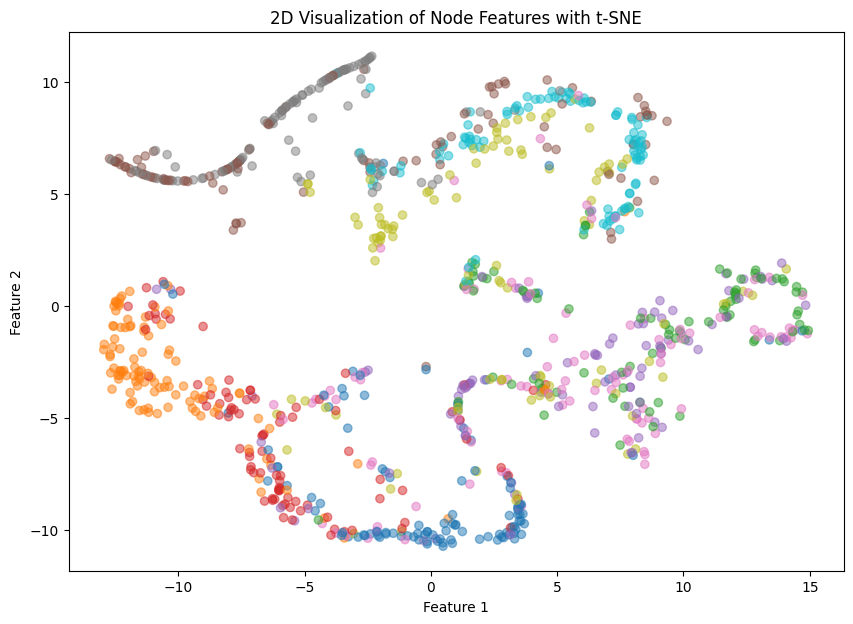

In [18]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [19]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [20]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.385802984237671
Epoch: 20, Loss: 1.3853338956832886
Epoch: 30, Loss: 1.385054588317871
Epoch: 40, Loss: 1.3850263357162476
Epoch: 50, Loss: 1.385025978088379
Epoch: 60, Loss: 1.384586215019226
Epoch: 70, Loss: 1.3846529722213745
Epoch: 80, Loss: 1.3841161727905273
Epoch: 90, Loss: 1.3837010860443115
Epoch: 100, Loss: 1.3842506408691406


## 

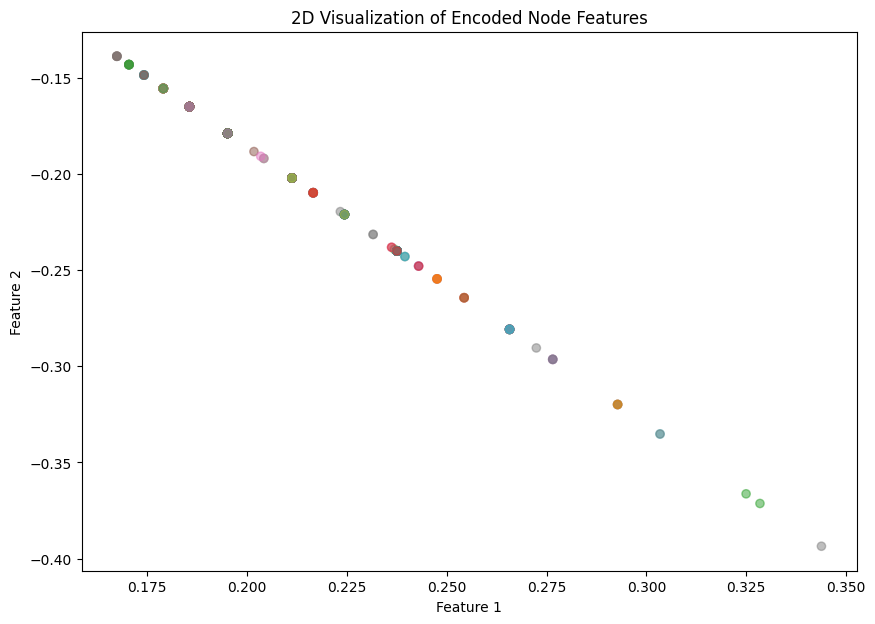

In [21]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [22]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [23]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 2.749391555786133
Epoch: 20, Loss: 1.8882992267608643
Epoch: 30, Loss: 1.5459964275360107
Epoch: 40, Loss: 1.397116780281067
Epoch: 50, Loss: 1.3858284950256348
Epoch: 60, Loss: 1.351940631866455
Epoch: 70, Loss: 1.3515408039093018
Epoch: 80, Loss: 1.372780203819275
Epoch: 90, Loss: 1.351826786994934
Epoch: 100, Loss: 1.3687561750411987
Epoch: 110, Loss: 1.3825535774230957
Epoch: 120, Loss: 1.351172924041748
Epoch: 130, Loss: 1.3556098937988281
Epoch: 140, Loss: 1.3690717220306396
Epoch: 150, Loss: 1.3462727069854736
Epoch: 160, Loss: 1.3518285751342773
Epoch: 170, Loss: 1.3563870191574097
Epoch: 180, Loss: 1.3491177558898926
Epoch: 190, Loss: 1.337019920349121
Epoch: 200, Loss: 1.3195993900299072


## 

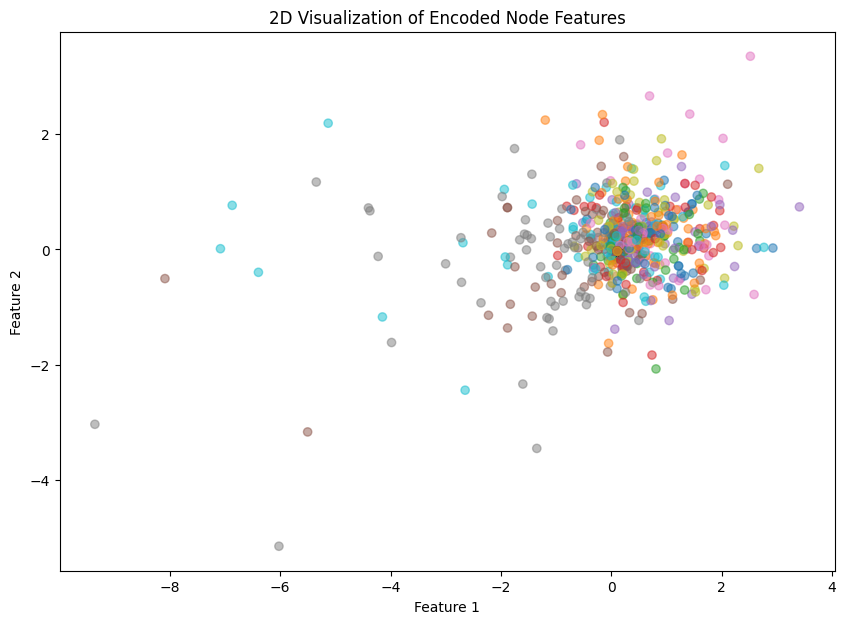

In [24]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [25]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [26]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 6.897848606109619
Epoch: 20, Loss: 5.485063076019287
Epoch: 30, Loss: 7.030309677124023
Epoch: 40, Loss: 7.62393045425415
Epoch: 50, Loss: 6.788002014160156
Epoch: 60, Loss: 5.887319564819336
Epoch: 70, Loss: 4.756706237792969
Epoch: 80, Loss: 5.739935398101807
Epoch: 90, Loss: 7.47143030166626
Epoch: 100, Loss: 6.606881618499756
Epoch: 110, Loss: 6.315474510192871
Epoch: 120, Loss: 6.510358810424805
Epoch: 130, Loss: 6.219437599182129
Epoch: 140, Loss: 6.106998443603516
Epoch: 150, Loss: 5.032489776611328
Epoch: 160, Loss: 6.99814510345459
Epoch: 170, Loss: 6.687802314758301
Epoch: 180, Loss: 6.195340633392334
Epoch: 190, Loss: 7.068141937255859
Epoch: 200, Loss: 6.295291900634766


## 

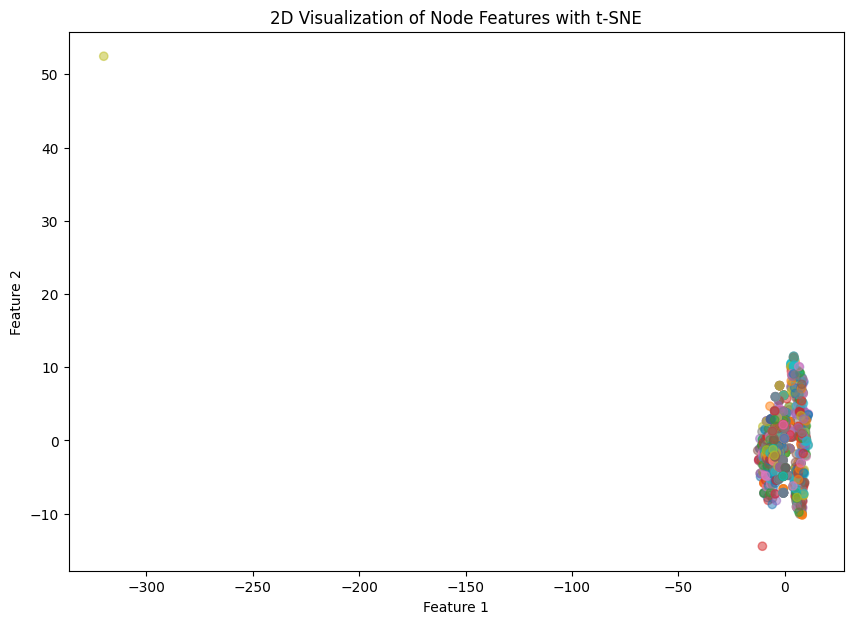

In [27]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [28]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [29]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3861690759658813
Epoch: 20, Loss: 1.385596513748169
Epoch: 30, Loss: 1.3852497339248657
Epoch: 40, Loss: 1.3851075172424316
Epoch: 50, Loss: 1.384971261024475
Epoch: 60, Loss: 1.3848423957824707
Epoch: 70, Loss: 1.3849799633026123
Epoch: 80, Loss: 1.3846533298492432
Epoch: 90, Loss: 1.3848201036453247
Epoch: 100, Loss: 1.3847463130950928
Epoch: 110, Loss: 1.3848052024841309
Epoch: 120, Loss: 1.3843786716461182
Epoch: 130, Loss: 1.3845114707946777
Epoch: 140, Loss: 1.384751796722412
Epoch: 150, Loss: 1.3845467567443848
Epoch: 160, Loss: 1.3845484256744385
Epoch: 170, Loss: 1.384502649307251
Epoch: 180, Loss: 1.384716272354126
Epoch: 190, Loss: 1.3839900493621826
Epoch: 200, Loss: 1.3843111991882324


## 

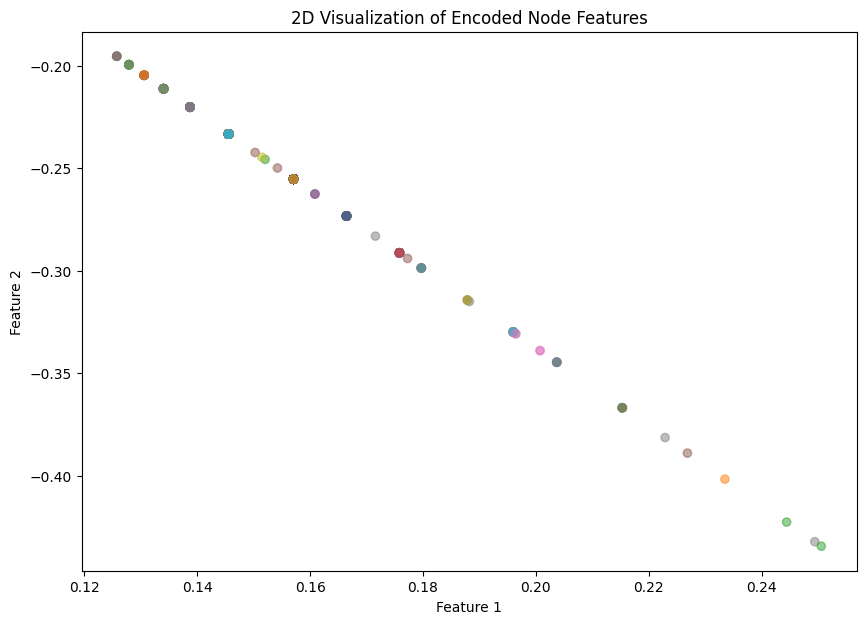

In [30]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [31]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [32]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 3.4379141330718994
Epoch: 20, Loss: 1.1975021362304688
Epoch: 30, Loss: 1.3232090473175049
Epoch: 40, Loss: 1.1437605619430542
Epoch: 50, Loss: 1.1354281902313232
Epoch: 60, Loss: 1.0520820617675781
Epoch: 70, Loss: 1.0741784572601318
Epoch: 80, Loss: 1.099164605140686
Epoch: 90, Loss: 1.0569015741348267
Epoch: 100, Loss: 1.0572680234909058
Epoch: 110, Loss: 1.1026861667633057
Epoch: 120, Loss: 1.0476670265197754
Epoch: 130, Loss: 1.0145957469940186
Epoch: 140, Loss: 1.0507090091705322
Epoch: 150, Loss: 1.0381033420562744
Epoch: 160, Loss: 1.0670379400253296
Epoch: 170, Loss: 1.0398197174072266
Epoch: 180, Loss: 1.0197964906692505
Epoch: 190, Loss: 1.0253335237503052
Epoch: 200, Loss: 1.021125316619873


## 

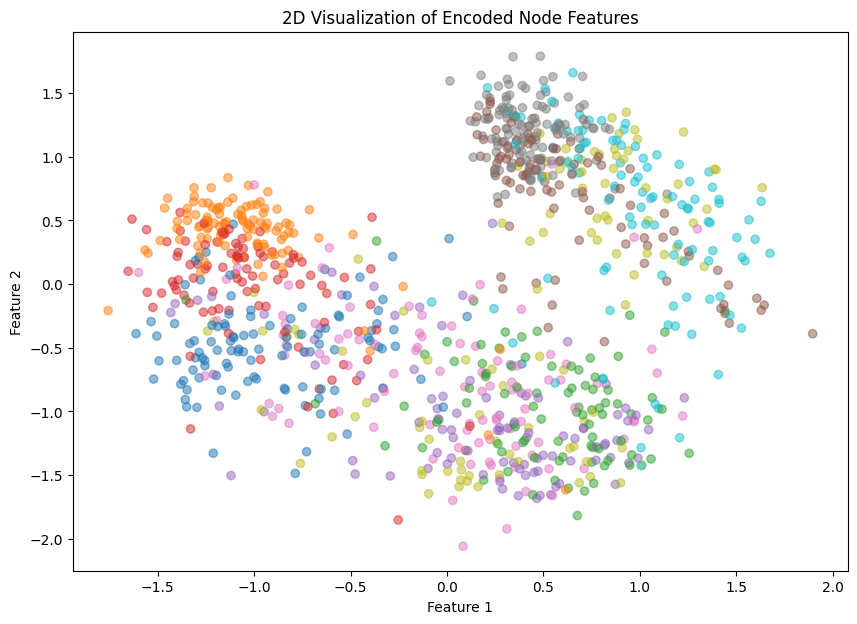

In [33]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [34]:
data = main()
generate_train_test(data)

Data(x=[1000, 784], edge_index=[2, 1000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


In [35]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3929848670959473
Epoch: 20, Loss: 1.3495869636535645
Epoch: 30, Loss: 1.3399107456207275
Epoch: 40, Loss: 1.3789585828781128
Epoch: 50, Loss: 1.3623836040496826
Epoch: 60, Loss: 1.3017568588256836
Epoch: 70, Loss: 1.357522964477539
Epoch: 80, Loss: 1.336198329925537
Epoch: 90, Loss: 1.3227806091308594
Epoch: 100, Loss: 1.3015837669372559
Epoch: 110, Loss: 1.3345112800598145
Epoch: 120, Loss: 1.3197977542877197
Epoch: 130, Loss: 1.2974390983581543
Epoch: 140, Loss: 1.3154218196868896
Epoch: 150, Loss: 1.3391327857971191
Epoch: 160, Loss: 1.3134099245071411
Epoch: 170, Loss: 1.3407371044158936
Epoch: 180, Loss: 1.2757796049118042
Epoch: 190, Loss: 1.297803282737732
Epoch: 200, Loss: 1.280590534210205


## 

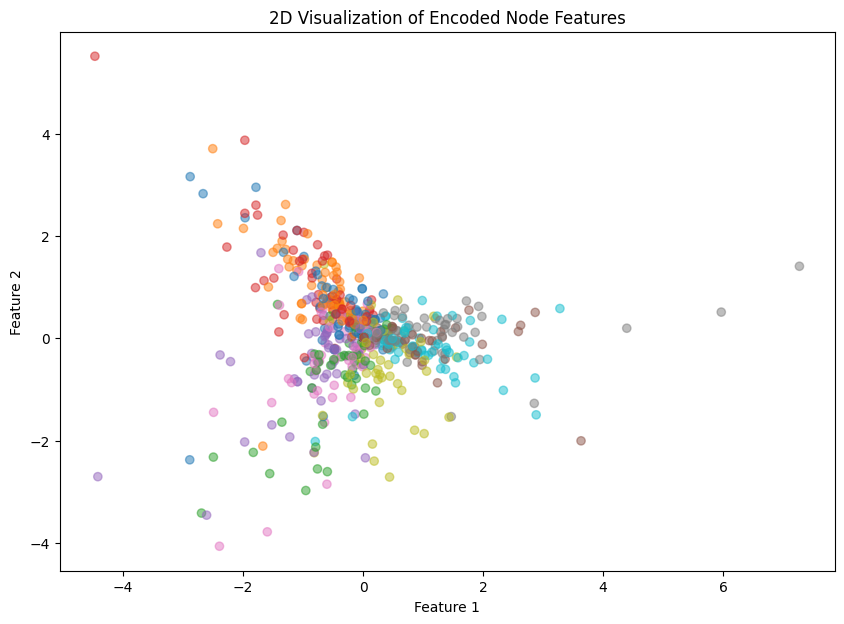

In [36]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')